In [130]:
import json
import requests
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from utils import *

API_GET_ENTRIES_URL ='http://localhost:8000/Covid/get_entries/'
HEADERS = {'Content-type': 'application/json'}

def get_api_data(filters={}):

    filters_data_json = json.dumps(filters)

    res = requests.get(url=API_GET_ENTRIES_URL, headers=HEADERS, data=filters_data_json)
    json_data = res.json()

    df = pd.json_normalize(json_data, record_path=['countries','entries'], meta=['continent',['countries','country']])
    df.rename(columns={'countries.country' : 'location'}, inplace=True)
    return df

def annotate_country_codes(df):
    has_codes = px.data.gapminder().query('year==2007')

    iso_map = {
        country: has_codes[has_codes['country']==country]['iso_alpha'].values[0] if len(has_codes[has_codes['country']==country]['iso_alpha'].values) else None
     for country in df.index.values
    }
    df["country_code"] = df.index.map(iso_map)
    return df


In [35]:
data_raw = get_api_data(filters)
data_raw.head()

,date,new_cases,new_cases_per_million,new_deaths,continent,country
0,2019-12-31,0.0,0.0,0.0,Africa,Algeria
1,2020-01-01,0.0,0.0,0.0,Africa,Algeria
2,2020-01-02,0.0,0.0,0.0,Africa,Algeria
3,2020-01-03,0.0,0.0,0.0,Africa,Algeria
4,2020-01-04,0.0,0.0,0.0,Africa,Algeria


['Falkland Islands', 'Uruguay', 'Suriname', 'Guyana', 'Venezuela', 'Paraguay', 'Chile', 'Bolivia', 'Peru', 'Ecuador']


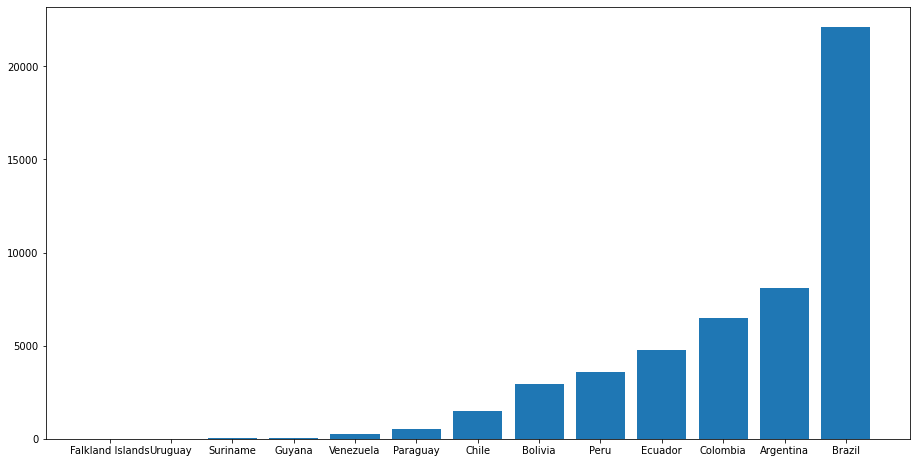

In [134]:
def zad1():
    period = ['2020-09-01', '2020-09-30']
    filters = {'continent_names' : ['South America']}

    data = get_api_data(filters)
    data = in_date_range(data, *period)
    result = least_lethal_countries(data)

    grouped = data.groupby('location').sum()
    sorted_by_lethality = grouped.sort_values(by='new_deaths', ascending=True)
    sorted_by_lethality.reset_index(inplace=True)

    fig = plt.figure(figsize=(12,6))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(sorted_by_lethality['location'], sorted_by_lethality['new_deaths'])
 
    print(result)
    fig.show()

zad1()

{'Africa': 'Equatorial Guinea', 'Asia': 'Kyrgyzstan', 'Europe': 'Vatican', 'North America': 'Aruba', 'Oceania': 'French Polynesia', 'South America': 'Chile'}


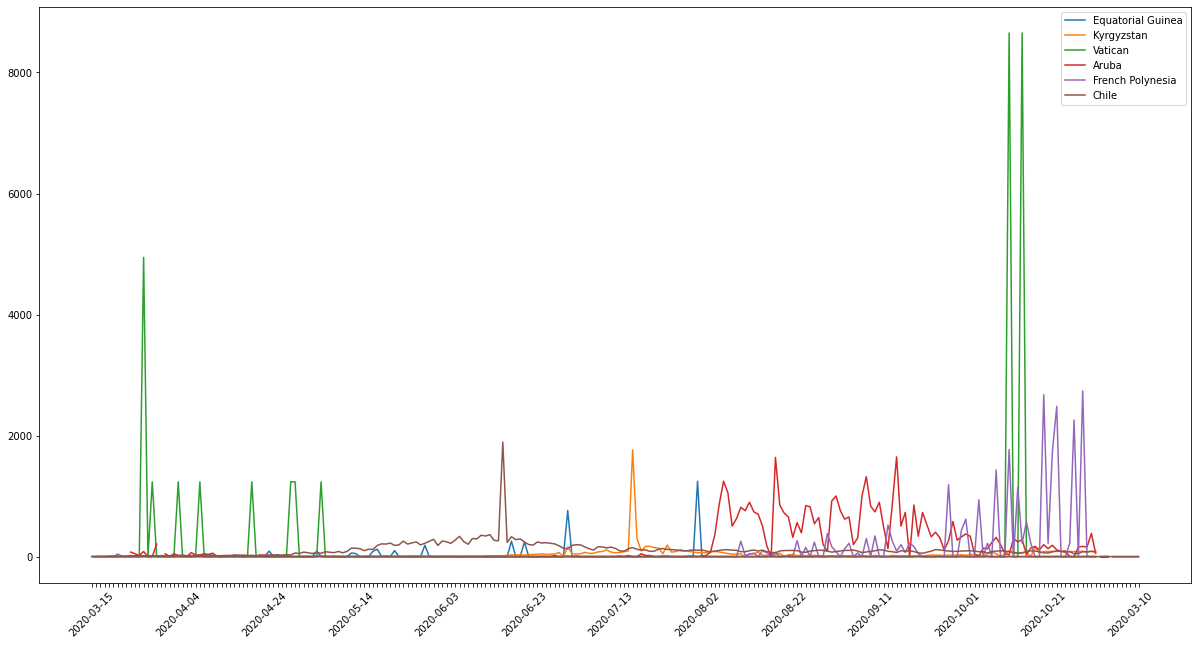

In [168]:
def zad2():
    data = get_api_data()
    result = most_new_cases_per_million(data)
    print(result)

    #graph 1
    fig = plt.figure(figsize=(16,8))
    for continent,country in result.items():
        country_data = data[data['location']==country]
        ax = fig.add_axes([0,0,1,1])
        ax.plot(country_data['date'],country_data['new_cases_per_million'], label=country)
        ax.legend()
    ax = plt.gca()
    temp = ax.xaxis.get_ticklabels()
    temp = list(set(temp) - set(temp[::20]))

    plt.xticks(rotation=45)
    for label in temp:
        label.set_visible(False)
    fig.show()

    #graph 2
    grouped = data.groupby('location').sum()
    annotated = annotate_country_codes(grouped)
    grouped.reset_index(inplace=True)

    fig = px.choropleth(annotated, locations='country_code', color='new_cases_per_million', hover_name='location')
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},width=1200, height=600)
    fig.show()

zad2()

['India', 'Brazil', 'Argentina', 'United States', 'Colombia']


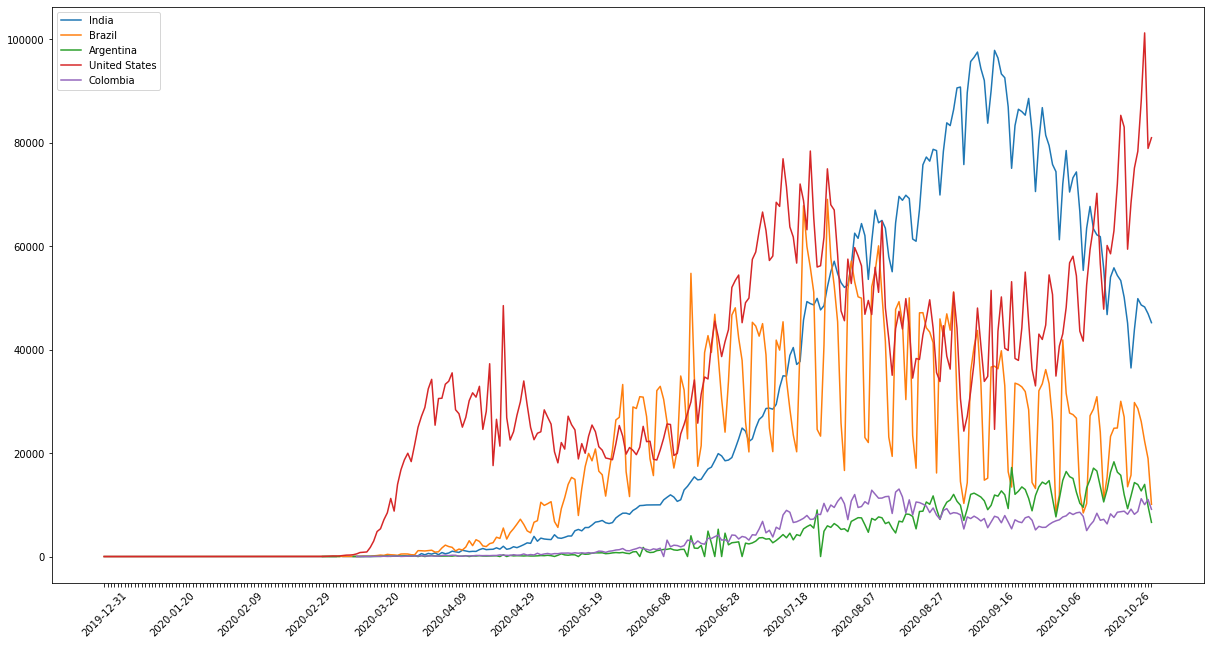

In [150]:
def zad3():
    first_period = ['2020-04-01', '2020-04-30']
    second_period = ['2020-09-01', '2020-09-30']
    filters = {'continent_names' :['South America']}

    data = get_api_data()
    result = highest_daily_cases_increase(data, first_period, second_period)

    fig = plt.figure(figsize=(16,8))
    for country in result:
        country_data = data[data['location']==country]
        ax = fig.add_axes([0,0,1,1])
        ax.plot(country_data['date'],country_data['new_cases'], label=country)
        ax.legend()
    ax = plt.gca()
    temp = ax.xaxis.get_ticklabels()
    temp = list(set(temp) - set(temp[::20]))

    plt.xticks(rotation=45)
    for label in temp:
        label.set_visible(False)
    print(result) 
    plt.show()

zad3()

In [160]:
def zad4():
    filters={'continent_names' :['Africa']}
    first_period = ['2020-04-01', '2020-04-30']
    second_period = ['2020-09-01', '2020-09-30']

    def annotate_avg_daily_cases(period):
        def categorize(avg):
            return 1 if avg < max_avg/3 else (2 if avg < max_avg/3*2 else 3)

        df = average_daily_cases(data, period)
        max_avg = df['avg_daily_cases'].max()
        df['category'] = df['avg_daily_cases'].apply(categorize)
        return df

    data = get_api_data(filters)
    data_first = in_date_range(data, *first_period)
    data_second = in_date_range(data, *second_period)

    common_countries = set(data_first.groupby('location').groups.keys()
                           ) & set(data_second.groupby('location').groups.keys())

    data = data[data['location'].isin(common_countries)]
    categorized_first = annotate_avg_daily_cases(first_period)
    categorized_second = annotate_avg_daily_cases(second_period)
    result = [
        first[0] for first, second
        in zip(categorized_first.iterrows(), categorized_second.iterrows())
        if first[1][1] > second[1][1]
    ]

    annotated = annotate_country_codes(categorized_second)
    annotated.reset_index(inplace=True)

    fig = px.choropleth(annotated, locations='country_code', color='avg_daily_cases', hover_name='location', scope='africa')
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},width=1200, height=600)

 
    print(result)
    fig.show()

zad4()

['Niger', 'Sao Tome and Principe', 'Seychelles', 'Tanzania', 'Western Sahara']
